# HW3 !

## Preparations

### Installs

In [1]:
!pip install torchvision

In [2]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-macosx_10_16_x86_64.whl (53.9 MB)


In [46]:
! pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 8.5 MB/s eta 0:00:0000:0100:01
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached tifffile-2023.4.12-py3-none-any.whl (219 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 7.4 MB/s eta 0:00:0000:0100:01
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)


### Imports

In [25]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import cv2

In [ ]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

In [67]:
from typing import Optional, Union, Tuple
import json


### Definitions

### Common functions

In [39]:
def get_top_k_predictions(results_tensor: torch.Tensor, k: int=3, mapping: Optional[dict] = None):
    # assumption: using the imagenet's 1000 classes
    topk_results = torch.topk(results_tensor, k=k)
    print(f"topk values\n{topk_results.values.tolist()}")
    print(f"topk indices\n{topk_results.indices.tolist()}")

    if mapping is not None:
        class_names = [mapping[index] for index in topk_results.indices.tolist()]
        print(f"class_names\n{class_names}")


### Optional: Label mapping

In [36]:

# Note: mapping between imagenet images and their labels was taken from https://www.kaggle.com/datasets/juliangarratt/imagenet-class-index-json?resource=download

path_to_mapping = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/imagenet_labels.json'

with open(path_to_mapping, 'rb') as fp:
    raw_label_mapping = json.load(fp)

    label_mapping = {
        int(key): value[1]
        for key, value in raw_label_mapping.items()
    }

len(label_mapping)

1000

In [35]:
label_mapping["0"]

['n01440764', 'tench']

## Part 0 

### Choosing the model

In [4]:
model = resnet50(weights="IMAGENET1K_V2")

### Choosing the images

In [5]:
path_to_data_dir = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data'

# trainset = ImageNet(path_to_data_dir, split='train', download=True)

In [6]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

images taken from https://github.com/EliSchwartz/imagenet-sample-images

In [7]:
image_banana_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n07753592_banana.JPEG'
image_pizza_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n07873807_pizza.JPEG'
image_tennisball_path = '/Users/royrubin/PycharmProjects/AdvancedMachineLearning/HW3/data/n04409515_tennis_ball.JPEG'

In [8]:
image_banana = Image.open(image_banana_path)
image_pizza = Image.open(image_pizza_path)
image_tennisball = Image.open(image_tennisball_path)

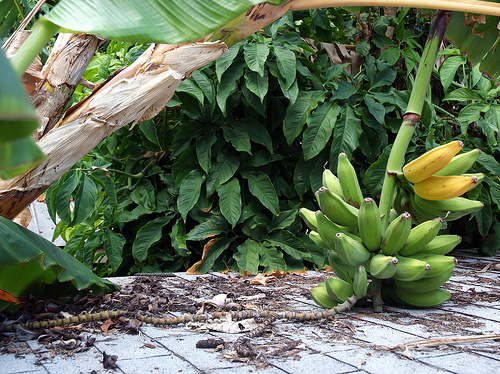

In [9]:
# display is a jupyter method
display(image_banana)

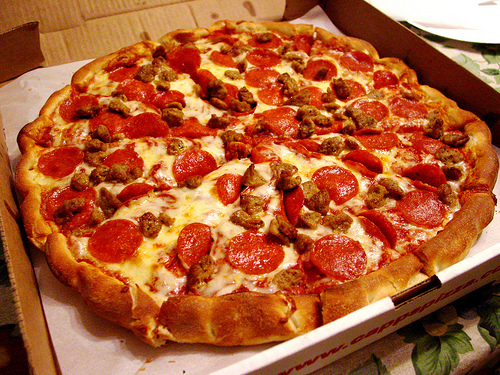

In [10]:
# display is a jupyter method
display(image_pizza)

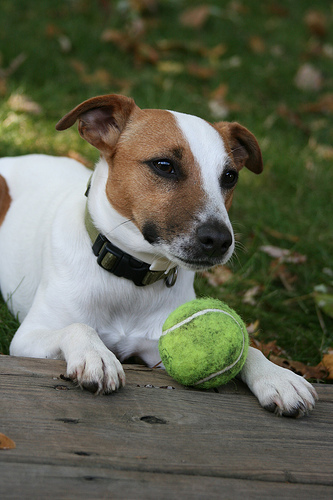

In [11]:
# display is a jupyter method
display(image_tennisball)

In [12]:
transform = transforms.Compose([transforms.PILToTensor()])

image_tensor_banana = transform(image_banana)
image_tensor_pizza = transform(image_pizza)
image_tensor_tennisball = transform(image_tennisball)

In [13]:
print(f"image_tensor_banana.shape {image_tensor_banana.shape}")
print(f"image_tensor_pizza.shape {image_tensor_pizza.shape}")
print(f"image_tensor_tennisball.shape {image_tensor_tennisball.shape}")

image_tensor_banana.shape torch.Size([3, 374, 500])
image_tensor_pizza.shape torch.Size([3, 375, 500])
image_tensor_tennisball.shape torch.Size([3, 500, 333])


## Part 1

For each image, 𝑥, perform the following: 

3) Get the top 3 classes from the model 𝑓!(𝑥),𝑓"(𝑥),𝑓#(𝑥) 

4) Interpretable (simplified) instances: 

    a) Generate interpretable versions of the images you chose by either splitting them to super-pixels. You can use the CV2 package for that.  
    b) Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$∈{0,1}%!
  
5) For each class perform 𝑓&: 

    a) Local dataset generation 

        i) Generate  a  set  of  random  perturbations  of  the  interpretable  instances  by  uniformly choosing which parts to include 𝑧$∈{0,1}%!
        
        ii) For each generated interpretable instance, generate the corresponding image 𝑧 and get its label 𝑓&(𝑧) 

        iii) Calculate the similarity of the perturbed instance from the original image 𝜋'(𝑧) 

    b) Fit a local surrogate model 𝑔 and generate explanations 

        i) Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the generated dataset. Use K-Lasso for feature selection. 
        ii) Find and present the set of important features (super-pixels/tiles) for the prediction 𝑓(𝑥)

### Part 1 Section 3)

In [16]:
transform_for_model = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    # for explanation on normalizatio values - see https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [18]:
image_tensor_banana_transformed = transform_for_model(image_banana)
image_tensor_banana_transformed.shape


In [21]:
image_tensor_banana_transformed = image_tensor_banana_transformed.unsqueeze(0)
image_tensor_banana_transformed.shape

torch.Size([1, 3, 256, 256])

In [22]:
result_banana = model(image_tensor_banana_transformed)
result_banana.shape

In [24]:
result_banana = result_banana.squeeze()
result_banana.shape

torch.Size([1000])

In [40]:
get_top_k_predictions(result_banana, mapping=label_mapping)

topk values
[0.585300624370575, 0.5333357453346252, 0.5080366730690002]
topk indices
[385, 101, 297]
class_names
['Indian_elephant', 'tusker', 'sloth_bear']


In [42]:
image_tensor_pizza_transformed = transform_for_model(image_pizza).unsqueeze(0)
result_pizza = model(image_tensor_pizza_transformed).squeeze()
result_pizza.shape

torch.Size([1000])

In [43]:
get_top_k_predictions(result_pizza, mapping=label_mapping)

topk values
[0.5078317523002625, 0.43483519554138184, 0.4182683527469635]
topk indices
[805, 839, 646]
class_names
['soccer_ball', 'suspension_bridge', 'maze']


In [44]:
image_tensor_tennisball_transformed = transform_for_model(image_tennisball).unsqueeze(0)  # unsqueeze to add batch size dimension (needed for the model)
result_tennisball = model(image_tensor_tennisball_transformed).squeeze()  # squeeze to remove batch size dimension
result_tennisball.shape

torch.Size([1000])

In [45]:
get_top_k_predictions(result_tennisball, mapping=label_mapping)

topk values
[1.510238528251648, 1.040035605430603, 0.9231462478637695]
topk indices
[852, 180, 162]
class_names
['tennis_ball', 'American_Staffordshire_terrier', 'beagle']


### Part 1 Section 4)
4) Interpretable (simplified) instances: 
a) Generate interpretable versions of the images you chose by either splitting them to super-
pixels. You can use the CV2 package for that.  
b) Represent the interpretable instances as binary vectors. The entries of the vector correspond 
to inclusion/exclusion of the super pixels 𝑥$∈{0,1}%!
 

In [ ]:

# read list:
## https://stackoverflow.com/questions/68530131/threshold-in-a-superpixel-opencv2
## https://pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/

In [14]:


# # Parameters
# IMG_FILE_PATH = 'PATH TO THE IMAGE'
# REGION_SIZE = 200
# RULER = 20
# N = 10
# SAMPLE_SIZE = 5
# INTENSITY_TH = 100
# # ---


# # 2) Compute the superpixels
# slic = cv2.ximgproc.createSuperpixelSLIC(image_banana, region_size=REGION_SIZE, ruler=RULER)


AttributeError: module 'cv2' has no attribute 'ximgproc'

type(image) <class 'numpy.ndarray'>
image.shape (256, 256, 3)
type(segments) <class 'numpy.ndarray'>
segments.shape (256, 256)
segments
 [[ 1  1  1 ... 10 10 10]
 [ 1  1  1 ... 10 10 10]
 [ 1  1  1 ... 10 10 10]
 ...
 [91 91 91 ... 93 93 93]
 [91 91 91 ... 93 93 93]
 [91 91 91 ... 93 93 93]]
actuall_num_of_segments
 97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


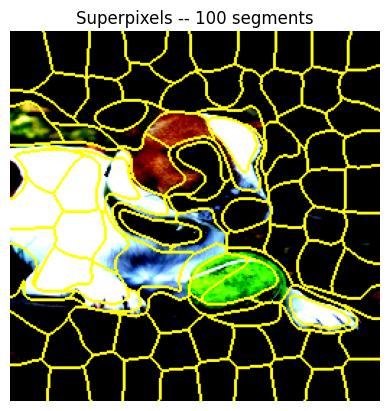

In [60]:

# SLIC parameters
number_of_segments_in_image = 100 # or 200 or 300
sigma = 5

# load the image and convert it to a floating point data type
# image = img_as_float(image_banana)  # use this if you want to use the original image, and not the verrsion passed to the model
image = image_tensor_tennisball_transformed.squeeze().permute(1,2,0).detach().numpy()  # squeeze to remove batch dimension, permute to move channel dimension to end (for plotting), detach to remove gradient tracking, convert to numpy
print(f"type(image) {type(image)}")
print(f"image.shape {image.shape}")

# apply SLIC and extract (approximately) the supplied number
# of segments
segments: np.ndarray = slic(image, n_segments=number_of_segments_in_image, sigma=sigma)
print(f"type(segments) {type(segments)}")
print(f"segments.shape {segments.shape}")
print(f"segments\n {segments}")

actuall_num_of_segments = segments.max()
print(f"actuall_num_of_segments: {actuall_num_of_segments}")


# show the output of SLIC
plt.figure(0)
plt.title(f"Superpixels -- {number_of_segments_in_image} segments")
plt.imshow(mark_boundaries(image, segments))
plt.axis("off")
# show the plots
plt.show()

In [65]:
#!!
# binaric_superpixel_vector = [0,1,0,0,0,0,1,1,0,1,0,....]
# superpixels_to_include_indices = np.where(binaric_superpixel_vector == 1)[0]

superpixels_to_include_indices = [40, 41, 42, 43, 44, 45, 
                                  50, 51, 52, 53, 54, 55, 
                                  73,74,75,76,
                                  ]

# make a mask, where all the non wanted superpixels will be masked (values == 0)
mask = np.where(np.isin(segments, test_elements=superpixels_to_include_indices), 1, 0)
print(f"mask.shape {mask.shape}")

# duplicate the 2d mask to 3d (so it can be applied to iamge)
mask_3d = np.dstack([mask] * 3)
print(f"mask_3d.shape {mask_3d.shape}")

# apply mask to image
image_masked = np.where(mask_3d == 1, image, 0) # can also be achieved by multiplication

mask.shape (256, 256)
mask_3d.shape (256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


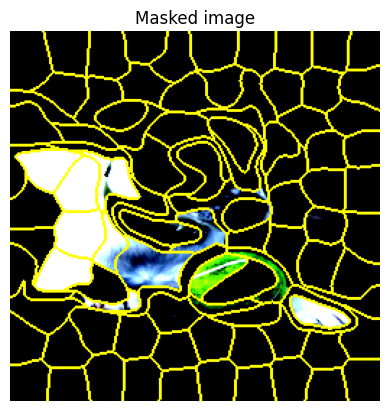

In [66]:
# show the output of SLIC
plt.figure(0)
plt.title(f"Masked image")
plt.imshow(mark_boundaries(image_masked, segments))
plt.axis("off")
# show the plots
plt.show()

In [ ]:
class SuperpixelImage:
    def __init__(self, input_image: Image, number_of_segments_in_image: int = 100, sigma: int = 5) -> None:
        # Treat image
        self.input_image: Image = input_image
        self.number_of_segments_in_image_expected: int = number_of_segments_in_image
        self.sigma = sigma
        self._calculate_segments()

        # Setup for later
        self.transform_for_model = transforms.Compose([
            transforms.Resize((256,256)),
            # transforms.CenterCrop((224,224)),
            transforms.ToTensor(),
            # for explanation on normalizatio values - see https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def _calculate_segments(self) -> None:
        self.segments: np.ndarray = slic(
            image, n_segments=self.number_of_segments_in_image_expected, sigma=self.sigma)

        self.number_of_segments_in_image_actual: int = self.segments.max()
        

    def prepare_for_model(self) -> torch.Tensor:
        print(f"Entered prepare_for_model")
        image_tensor_transformed = self.transform_for_model(self.input_image).unsqueeze(0)
        print(f"image_tensor_transformed.shape {image_tensor_transformed.shape}")

        if len(image_tensor_transformed) != 4:
            # AKA missing batch dimension
            image_tensor_transformed = image_tensor_transformed.unsqueeze(0)
            print(f"image_tensor_transformed.shape {image_tensor_transformed.shape}")

        return image_tensor_transformed

    def generate_random_pertrubation(self) -> Tuple[np.ndarray, np.ndarray]:
        print(f"Entered generate_random_pertrubation")
        # generate  random interpretation vector with values between (0, 1)
        # aka binaric_superpixel_vector
        random_interpretation_vector = np.random.randint(2, size=self.number_of_segments_in_image_actual)
        print(f"random_interpretation_vector.shape {random_interpretation_vector.shape}")

        # get indices and crea
        superpixels_to_include_indices = np.where(random_interpretation_vector == 1)[0]
        print(f"superpixels_to_include_indices.shape {superpixels_to_include_indices.shape}")

        # make a mask, where all the non wanted superpixels will be masked (values == 0)
        mask = np.where(np.isin(self.segments, test_elements=superpixels_to_include_indices), 1, 0)
        print(f"mask.shape {mask.shape}")

        # duplicate the 2d mask to 3d (so it can be applied to iamge)
        mask_3d = np.dstack([mask] * 3)
        print(f"mask_3d.shape {mask_3d.shape}")

        # apply mask to image
        image_masked = np.where(mask_3d == 1, image, 0) # can also be achieved by multiplication

        return image_masked, self.segments



In [ ]:
def plot_image_with_segments(input_image: Union[np.ndarray, torch.Tensor, Image], segments: np.ndarray, title: str = "") -> None:
    if input_image.shape[0] == 3:
        # change (CxHxW) to (HxWxC)
        input_image = input_image.permute(1,2,0)
    
    plt.figure(0)
    plt.title(title)
    plt.imshow(mark_boundaries(input_image, segments))
    plt.axis("off")
    # show the plots
    plt.show()

In [ ]:
def calculate_similarity():
    raise